## SVM - Bayesian Optimization

This notebook uses the Support Vector Machine to automate the categorization of each Iris flower based on the length and width measurements of their sepals and petals.

The notebook explores the Bayesian Optimization process for the automation of hyperparameter tuning, based on the implementation in https://github.com/thuijskens/bayesian-optimization

The notebook uses scikit-learn


### Load the data

In [1]:
from sklearn.datasets import load_iris
iris_dataset = load_iris()
print("Keys of iris_dataset: {}".format(iris_dataset.keys()))

Keys of iris_dataset: dict_keys(['data', 'target', 'target_names', 'DESCR', 'feature_names'])


In [2]:
print("Target names: {}".format(iris_dataset['target_names']))
print("Feature names: {}".format(iris_dataset['feature_names']))
print("Shape of data: {}".format(iris_dataset['data'].shape))
print("Shape of target: {}".format(iris_dataset['target'].shape))

Target names: ['setosa' 'versicolor' 'virginica']
Feature names: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Shape of data: (150, 4)
Shape of target: (150,)


### Train the data

In [3]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    iris_dataset['data'], iris_dataset['target'], random_state=0)

In [4]:
print("X_train shape: {}".format(X_train.shape))
print("y_train shape: {}".format(y_train.shape))
print("X_test shape: {}".format(X_test.shape))
print("y_test shape: {}".format(y_test.shape))

X_train shape: (112, 4)
y_train shape: (112,)
X_test shape: (38, 4)
y_test shape: (38,)


In [5]:
from sklearn.svm import SVC

In [6]:
svc = SVC(kernel='rbf', C=10, gamma=0.1)
svc.fit(X_train, y_train)    
print("Accuracy on training set: {:.2f}".format(svc.score(X_train, y_train)))
print("Accuracy on test set: {:.2f}".format(svc.score(X_test, y_test)))

Accuracy on training set: 0.99
Accuracy on test set: 0.97


### NN vs SVM

We see that the test set accuracy is comparable for SVM and NN

### Scale SVM data

In [7]:
# Compute the minimum value per feature on the training set
min_on_training = X_train.min(axis=0)
# Compute the range of each feature (max - min) on the training set
range_on_training = (X_train - min_on_training).max(axis=0)

# subtract the min, divide by range
# afterwards min=0 and max=1 for each feature
X_train_scaled = (X_train - min_on_training) / range_on_training
print("Minimum for each feature\n{}".format(X_train_scaled.min(axis=0)))
print("Maximum for each feature\n {}".format(X_train_scaled.max(axis=0)))

Minimum for each feature
[0. 0. 0. 0.]
Maximum for each feature
 [1. 1. 1. 1.]


In [8]:
# use the same transformation on the test set,
# using min and range of the training set.
X_test_scaled = (X_test - min_on_training) / range_on_training

In [9]:
svc = SVC(kernel='rbf', C=10, gamma=0.1)
svc.fit(X_train_scaled, y_train)

print("Accuracy on training set: {:.3f}".format(
        svc.score(X_train_scaled, y_train)))
print("Accuracy on test set: {:.3f}".format(svc.score(X_test_scaled, y_test)))

Accuracy on training set: 0.973
Accuracy on test set: 0.974


Scaling the data does not make a big difference in the Iris classification, but can make a big difference when you have features that have orders of magnitude difference in their values

## Hyperparameter tuning

Optimize penalization parameter $C$ and the kernel parameter $\gamma$

The loss function used is the cross validated area under the curve (AUC) based on three folds (this does not work with multi-class labels)

In [10]:
%matplotlib inline

# Load the Python scripts that contain the Bayesian optimization code
%run ./python/gp1.py
%run ./python/plotters.py

In [11]:
from sklearn.model_selection import cross_val_score
import numpy as np

In [12]:
def sample_loss(params):
    
    C = params[0]
    
    gamma = params[1]
    
    # Sample C and gamma on the log-uniform scale
    model = SVC(C=10 ** C, gamma=10 ** gamma, random_state=12345)

    # Sample parameters on a log scale
    return cross_val_score(model,
                         X=X_train,
                         y=y_train,
                         #scoring='roc_auc',
                         cv=3).mean()

Compute the loss surface as a function of $C$ and $\gamma$ to get an accurate estimate of where the true optimum of the loss surface is

In [19]:
lambdas = np.linspace(1, -4, 5)
gammas = np.linspace(1, -4, 5)

# We need the cartesian combination of these two vectors
param_grid = np.array([[C, gamma] for gamma in gammas for C in lambdas])

In [20]:
real_loss = [sample_loss(params) for params in param_grid]

# The maximum is at:
param_grid[np.array(real_loss).argmax(), :]

array([ 1. , -1.5])

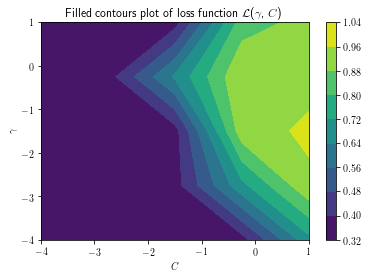

In [21]:
from matplotlib import rc
rc('text', usetex=True)

C, G = np.meshgrid(lambdas, gammas)
plt.figure()
cp = plt.contourf(C, G, np.array(real_loss).reshape(C.shape))
plt.colorbar(cp)
plt.title('Filled contours plot of loss function $\mathcal{L}$($\gamma$, $C$)')
plt.xlabel('$C$')
plt.ylabel('$\gamma$')
plt.savefig('real_loss_contour.png', bbox_inches='tight')
plt.show()

For the underlying GP, we'll assume a [Matern](http://scikit-learn.org/stable/modules/gaussian_process.html#matern-kernel) kernel as the covariance function. Using a Matern kernel, with the default parameters, means we implicitly assume the loss $f$ is at least once differentiable. [There are a number of kernels available](http://scikit-learn.org/stable/modules/gaussian_process.html#kernels-for-gaussian-processes) in scikit-learn, and each kernel implies a different assumption on the behaviour of the loss $f$.

In [22]:
bounds = np.array([[-4, 1], [-4, 1]])

# Run the Bayesian optimization algorithm
# This defines a Gaussian process
# updates the loss function
# samples the next hyperparameter by computing:
# the arg max of the acquisiton function (in this case - Expected improvement)
# evaluates the loss for the new hyperparameters
# updates the train and test data

xp, yp = bayesian_optimisation(n_iters=3, 
                               sample_loss=sample_loss, 
                               bounds=bounds,
                               n_pre_samples=3,
                               random_search=100000)

The animation below shows the sequence of points selected, if we run the Bayesian optimization algorithm in this setting. The star shows the value of $C$ and $\gamma$ that result in the largest value of the loss function (cross-validated AUC).

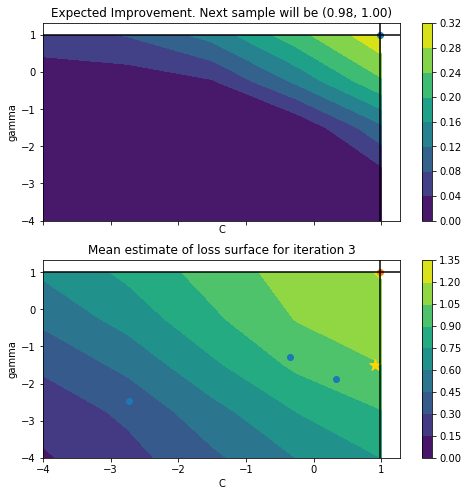

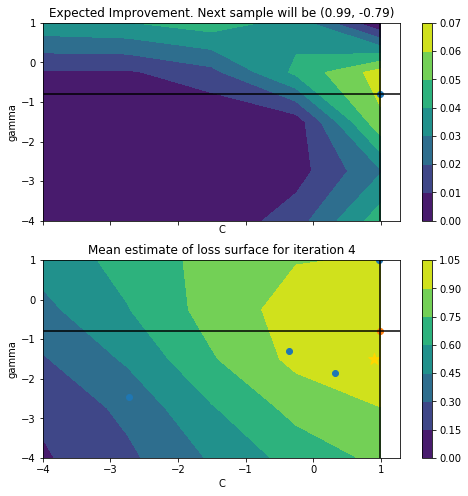

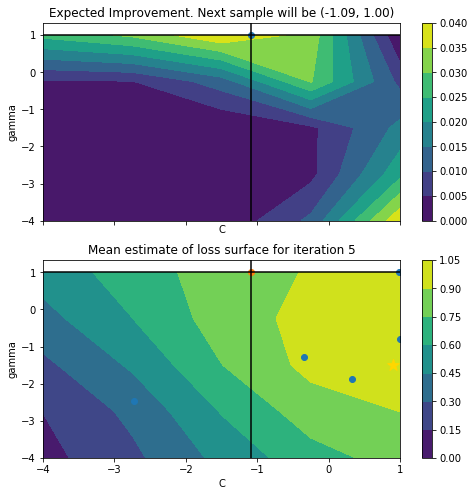

In [25]:
rc('text', usetex=False)

# plot a heatmap of the estimated loss function and 
# expected improvement acquisition function for each iteration of the Bayesian search algorithm.
plot_iteration(lambdas, xp, yp, first_iter=2, second_param_grid=gammas,
                optimum=[0.9, -1.5], filepath='.')